# <center> DATA572 Project <center>

##### <center> Group members: Amali Jayatileke, Vidal Mendoza Tinoco, and Kelsey Strachan <center>

---

## <ins> Exploratory Data Analysis (EDA) </ins>

In [1]:
# Imports packages necessary for data analysis
import warnings
import altair as alt
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical

warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
# Reads in milknew.csv file to perform EDA
full_milk = pd.read_csv("milknew.csv")

In [3]:
# Visualizes first 5 rows. Sets styles for table titles going forward
styles = [
    dict(selector="caption", props=[("font-size", "120%"), ("font-weight", "bold")])
]

full_milk.head().style.set_caption(
    "Table 1. First 5 Rows of Full Milk Data"
).set_table_styles(styles)

,pH,Temprature,Taste,Odor,Fat,Turbidity,Colour,Grade
0,6.600000,35,1,0,1,0,254,high
1,6.600000,36,0,1,0,1,253,high
2,8.500000,70,1,1,1,1,246,low
3,9.500000,34,1,1,0,1,255,low
4,6.600000,37,0,0,0,0,255,medium


In [4]:
# Renaming temperature column due to typographical error
full_milk = full_milk.rename(columns={"Temprature": "Temperature", "Fat ":"Fat"})

In [5]:
# Visualizes first 5 rows. Sets styles for table titles going forward
styles = [
    dict(selector="caption", props=[("font-size", "120%"), ("font-weight", "bold")])
]

full_milk.head().style.set_caption(
    "Table 2. Updated Full Milk Data"
).set_table_styles(styles)

,pH,Temperature,Taste,Odor,Fat,Turbidity,Colour,Grade
0,6.600000,35,1,0,1,0,254,high
1,6.600000,36,0,1,0,1,253,high
2,8.500000,70,1,1,1,1,246,low
3,9.500000,34,1,1,0,1,255,low
4,6.600000,37,0,0,0,0,255,medium


Each columns' `dtype` is observed by calling `.info()` on the `full_milk` dataframe. Null values noted will be addressed and filled with `missing`, `median`, or `most_frequent` using `SimpleImputer()` strategy.

In [6]:
# Calls info on full_milk data
milk_info = full_milk.info()
milk_info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1059 entries, 0 to 1058
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   pH           1059 non-null   float64
 1   Temperature  1059 non-null   int64  
 2   Taste        1059 non-null   int64  
 3   Odor         1059 non-null   int64  
 4   Fat          1059 non-null   int64  
 5   Turbidity    1059 non-null   int64  
 6   Colour       1059 non-null   int64  
 7   Grade        1059 non-null   object 
dtypes: float64(1), int64(6), object(1)
memory usage: 66.3+ KB


In [7]:
# Calls describe on full_milk data
milk_stats = (
    full_milk.describe(include="all")
    .style.set_caption("Table 3. Statistics of Full Milk Data")
    .set_table_styles(styles)
)
milk_stats

,pH,Temperature,Taste,Odor,Fat,Turbidity,Colour,Grade
count,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059
unique,nan,nan,nan,nan,nan,nan,nan,3
top,nan,nan,nan,nan,nan,nan,nan,low
freq,nan,nan,nan,nan,nan,nan,nan,429
mean,6.630123,44.226629,0.546742,0.432483,0.671388,0.491029,251.840415,nan
std,1.399679,10.098364,0.498046,0.495655,0.469930,0.500156,4.307424,nan
min,3.000000,34.000000,0.000000,0.000000,0.000000,0.000000,240.000000,nan
25%,6.500000,38.000000,0.000000,0.000000,0.000000,0.000000,250.000000,nan
50%,6.700000,41.000000,1.000000,0.000000,1.000000,0.000000,255.000000,nan
75%,6.800000,45.000000,1.000000,1.000000,1.000000,1.000000,255.000000,nan


---

In [8]:
numerical_features = ['pH', 'Temperature', 'Colour']

charts = []

for feature in numerical_features:
    chart = alt.Chart(full_milk).mark_bar(color='#472c7a'
                                         ).encode(
        x=alt.X(feature, bin=alt.Bin(maxbins=20), title=f"{feature} Distribution"),
        y=alt.Y('count()', title='Count'),
    ).properties(
        title=f"{feature} Distribution",
        width=225,
        height=250
    )
    charts.append(chart)

horizontal_charts = alt.hconcat(*charts)

horizontal_charts.display()

alt.HConcatChart(...)

The graph above shows that most samples have a pH close to 7.0, with some variations towards more extreme values. Temperature is mainly between 35°C and 45°C, which could represent typical storage conditions, although there are extreme values ​​outside this range. Regarding color, most samples have values ​​close to 254, with some secondary peaks reflecting slight variations. These distributions suggest characteristics consistent with a controlled product, but with some variability that could influence its quality.

In [9]:
if not isinstance(full_milk['Grade'].dtype, CategoricalDtype):
    full_milk['Grade'] = pd.Categorical(
        full_milk['Grade'],
        categories=['low', 'medium', 'high'],
        ordered=True
    )

categorical_features = ['Taste', 'Odor', 'Fat', 'Turbidity']

base = alt.Chart(full_milk).mark_bar(
    size=50,
    cornerRadius=3  
).encode(
    y=alt.Y('count()', title='Count'),
    color=alt.Color(
        'Grade:N',
        title='Grade',
        scale=alt.Scale(
            domain=['low', 'medium', 'high'],
            range=['#440154', '#20938C','#6ACC64'] 
        ),
        sort=['low', 'medium', 'high']  
    ),
    tooltip=[alt.Tooltip('Grade:N', title='Grade'), 
             alt.Tooltip('count()', title='Count')]
)
charts = []
for feature in categorical_features:
    chart = base.encode(
        x=alt.X(f'{feature}:N', 
               title=feature.capitalize(), 
               axis=alt.Axis(labelAngle=0))  
    ).properties(
        title=f"Distribution of {feature.capitalize()} by Grade",
        width=200,
        height=200
    )
    charts.append(chart)
    
row1 = alt.hconcat(charts[0], charts[1])
row2 = alt.hconcat(charts[2], charts[3])

horizontal_charts = alt.vconcat(row1, row2).resolve_scale(
    color='shared' 
).configure_view(
    stroke='transparent'  
).configure_axis(
    labelFontSize=12,
    titleFontSize=14
).configure_title(
    fontSize=16,
    anchor='middle'
)

horizontal_charts.display()

alt.VConcatChart(...)

The output above shows how the satisfaction of optimal conditions for Taste, Odor, Fat, and Turbidity (where 1 = optimal, 0 = suboptimal) relates to the Grade (low, medium, high). When features are suboptimal (0), they are strongly associated with medium grade (e.g., Fat = 0 is almost exclusively tied to medium grade). In contrast, when features are optimal (1), they are more likely linked to low or high grades, with Taste = 1, Odor = 1, and Turbidity = 1 showing significant occurrences in both low and high grades. Interestingly, Fat = 1 is strongly associated with both low and high grades, suggesting it plays a key role in distinguishing these extremes. Overall, optimal conditions (1) tend to push samples toward low or high grades, while suboptimal conditions (0) are strongly tied to medium grade, highlighting clear patterns that can inform quality assessment and predictive modeling.

In [10]:
# Calculate correlation matrix
correlation_data = (
    full_milk[numerical_features]
    .corr()
    .stack()
    .reset_index(name='Correlation')  
)

correlation_data.columns = ['Variable 1', 'Variable 2', 'Correlation']

# Create the correlation heatmap
correlation_chart = (
    alt.Chart(correlation_data)
    .mark_rect(stroke='white', strokeWidth=1)  
    .encode(
        x=alt.X('Variable 1:N', title=None, sort='ascending'),  
        y=alt.Y('Variable 2:N', title=None, sort='ascending'),
        color=alt.Color(
            'Correlation:Q',
            title='Correlation',
            scale=alt.Scale(scheme='viridis', domain=[-1, 1]),  
            legend=alt.Legend(orient='bottom', titleLimit=300)  
        ),
        tooltip=[
            alt.Tooltip('Variable 1:N', title='Variable 1'),
            alt.Tooltip('Variable 2:N', title='Variable 2'),
            alt.Tooltip('Correlation:Q', title='Correlation', format='.2f')  
        ]
    )
    .properties(
        title={
            "text": "Correlation Matrix of Numerical Features",
            "fontSize": 16,
            "anchor": "middle"
        },
        width=250,
        height=250
    )
     .configure_axis(
        labelFontSize=12,
        titleFontSize=14,
        labelAngle=0  
    )
    .configure_view(
        strokeWidth=0  
    )
    .configure_title(
        fontSize=18,
        anchor='middle'
    )
)

# Display the chart
correlation_chart.display()

alt.Chart(...)


The correlation data above reveals the relationships between pH, Temperature, and Colour. pH and Temperature show a weak positive correlation (0.24), suggesting a slight tendency for pH to increase as Temperature rises. In contrast, pH and Colour have a weak negative correlation (-0.16), indicating a minor tendency for pH to decrease as Colour intensifies. Temperature and Colour show almost no correlation (-0.01), implying no meaningful linear relationship. Overall, the correlations are weak, indicating that these features are largely independent of each other, with no strong linear dependencies.

In [11]:
base = alt.Chart(full_milk).mark_boxplot(
    size=40,  
    extent=0.5, 
    outliers=True  
).encode( 
    x=alt.X(
        'Grade:N',
        title='Grade',
        sort=['low', 'medium', 'high'],  
        axis=alt.Axis(labelAngle=0)  
    ),
    color=alt.Color(
        'Grade:N',
        title='Grade',
        scale=alt.Scale(
            domain=['low', 'medium', 'high'],
            range=['#440154', '#20938C','#6ACC64']
        ),
        legend=None  
    ),
    tooltip=[
        alt.Tooltip('Grade:N', title='Grade'),
        alt.Tooltip(f'{feature}:Q', title=feature, format='.2f')  
    ]
).properties(
    width=250,  
    height=250
)
# Create a list of charts for each numerical feature
charts = [
    base.encode(
        y=alt.Y(
            f'{feature}:Q',
            title=feature.capitalize(),  
            scale=alt.Scale(zero=False)  
        )
    ).properties(
        title=f"Distribution of {feature.capitalize()} by Grade"  
    )
    for feature in numerical_features
]

# Combine charts horizontally with shared configuration
final_chart = alt.hconcat(
    *charts
).resolve_scale(
    color='shared'  
).configure_view(
    stroke='transparent'  
).configure_axis(
    labelFontSize=12,
    titleFontSize=14
).configure_title(
    fontSize=16,
    anchor='middle'
)

# Display the final chart
final_chart.display()

alt.HConcatChart(...)

The plot above reveals distinct patterns in the distributions of pH, Temperature, and Colour across low, medium, and high grades. For pH, the low grade shows much greater variability compared to the tightly clustered medium and high grades. For Temperature, the low grade has a wider range compared to medium and high, indicating greater variability in low grade samples. For Colour, low and high have similar ranges, but the medium grade shows higher variability. Overall, pH and Temperature are more variable in low grade samples, while Colour remains relatively consistent across grades.

In [12]:
# Create a list to store scatterplots
scatterplots = []

# Generate scatterplots for pairwise combinations of numerical features
for i, x_feature in enumerate(numerical_features):
    for j, y_feature in enumerate(numerical_features):
        if x_feature != y_feature:
            scatterplot = alt.Chart(full_milk).mark_point(
                size=30,  
                opacity=0.7,  
                filled=True  
            ).encode(
                x=alt.X(
                    f'{x_feature}:Q',
                    title=x_feature.capitalize(),  
                    scale=alt.Scale(zero=False)  
                ),
                y=alt.Y(
                    f'{y_feature}:Q',
                    title=y_feature.capitalize(),
                    scale=alt.Scale(zero=False)
                ),
                color=alt.Color(
                    'Grade:N',
                    title='Grade',
                    scale=alt.Scale(
                        domain=['low', 'medium', 'high'],
                        range=['#440154', '#20938C','#6ACC64']  
                    ),
                    legend=alt.Legend(orient='bottom')  
                ),
                tooltip=[
                    alt.Tooltip(x_feature, title=x_feature.capitalize(), format='.2f'),
                    alt.Tooltip(y_feature, title=y_feature.capitalize(), format='.2f'),
                    alt.Tooltip('Grade:N', title='Grade')
                ]
            ).properties(
                width=200,  
                height=200,
                title=f"{x_feature.capitalize()} vs {y_feature.capitalize()}"  
            )
            scatterplots.append(scatterplot)
row_1 = alt.hconcat(
    scatterplots[0], scatterplots[1], scatterplots[2] 
)

row_2 = alt.hconcat(
    scatterplots[3], scatterplots[4], scatterplots[5]  
)

pairplot = alt.vconcat(
    row_1,
    row_2
).resolve_scale(
    color='shared'
).configure_view(
    stroke='transparent'  
).configure_axis(
    labelFontSize=10,
    titleFontSize=12
).configure_title(
    fontSize=14,
    anchor='middle'
)

# Display the final plot
pairplot.display()

alt.VConcatChart(...)

## <ins> Methods & Results </ins>

### Data preprocessing:

In [13]:
# Encode categorical features (Taste, Odor, Fat, Turbidity)
qualitative_features = ['Taste', 'Odor', 'Fat', 'Turbidity']
for col in qualitative_features:
    full_milk[col] = LabelEncoder().fit_transform(full_milk[col])

In [14]:
# Standardize quantitative features (pH, Temperature, Colour)
scaler = StandardScaler()
quantitative_features = ['pH', 'Temperature', 'Colour']
full_milk[quantitative_features] = scaler.fit_transform(full_milk[quantitative_features])

In [41]:
# Separate features and target variable
X = full_milk.drop('Grade', axis=1)
y = LabelEncoder().fit_transform(full_milk['Grade'])  # Encode target variable

In [42]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Data resampling:

In [43]:
# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(random_state=42)
}

In [44]:
# Data resampling using cross validation
fitted_models = {}
for name, model in models.items():
    print(f"\nCross validation for {name}...")
    results = cross_validate(model, X, y, cv=5, scoring='accuracy', return_train_score=True)
    cv_milk = pd.DataFrame(results)
    print(cv_milk)

    # Calculate mean and standard deviation of accuracy
    mean_test_score = cv_milk['test_score'].mean()
    std_test_score = cv_milk['test_score'].std()
    mean_train_score = cv_milk['train_score'].mean()
    std_train_score = cv_milk['train_score'].std()
    
    # Print summarized results
    print(f"Mean Test Accuracy: {mean_test_score:.2f} ± {std_test_score:.2f}")
    print(f"Mean Train Accuracy: {mean_train_score:.2f} ± {std_train_score:.2f}")
    
    # Fit the model on the entire dataset
    model.fit(X, y)
    fitted_models[name] = model  # Save the fitted model


Cross validation for Logistic Regression...
   fit_time  score_time  test_score  train_score
0  0.014440    0.001362    0.849057     0.854782
1  0.004840    0.000851    0.844340     0.855962
2  0.005457    0.001049    0.853774     0.853601
3  0.004886    0.000923    0.853774     0.850059
4  0.005275    0.001095    0.857820     0.849057
Mean Test Accuracy: 0.85 ± 0.01
Mean Train Accuracy: 0.85 ± 0.00

Cross validation for K-Nearest Neighbors...
   fit_time  score_time  test_score  train_score
0  0.001423    0.006081    0.995283     0.995277
1  0.001256    0.004796    1.000000     0.994097
2  0.001004    0.004216    1.000000     0.994097
3  0.000960    0.003978    1.000000     0.994097
4  0.000903    0.004030    0.981043     0.996462
Mean Test Accuracy: 1.00 ± 0.01
Mean Train Accuracy: 0.99 ± 0.00

Cross validation for Random Forest...
   fit_time  score_time  test_score  train_score
0  0.062388    0.003961    0.990566          1.0
1  0.061626    0.003937    1.000000          1.0
2  0.0

### Model building and training:

In [45]:
for name, model in models.items():
    print(f"\nModel fitting for {name}...")
    fitted_models[name]
    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)


Model fitting for Logistic Regression...
Accuracy: 0.8301886792452831

Model fitting for K-Nearest Neighbors...
Accuracy: 0.9952830188679245

Model fitting for Random Forest...
Accuracy: 1.0


### Hyperparameter tuning:

In [46]:
# Hyperparameter tuning using GridSearchCV
param_grids = {
    'Logistic Regression': {'C': [0.01, 0.1, 1, 10, 100]},
    'K-Nearest Neighbors': {'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance']},
    'Random Forest': {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20, 30]}
}

In [47]:
tuned_models = {}
for name, model in models.items():
    print(f"Tuning hyperparameters for {name}...")
    grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='accuracy', verbose=1)
    grid_search.fit(X_train, y_train)
    tuned_models[name] = grid_search.best_estimator_
    print(f"Best parameters for {name}: {grid_search.best_params_}")

Tuning hyperparameters for Logistic Regression...
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters for Logistic Regression: {'C': 1}
Tuning hyperparameters for K-Nearest Neighbors...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters for K-Nearest Neighbors: {'n_neighbors': 3, 'weights': 'uniform'}
Tuning hyperparameters for Random Forest...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters for Random Forest: {'max_depth': None, 'n_estimators': 50}


### Model evaluation


Evaluating Logistic Regression...
Accuracy for Logistic Regression: 0.83
              precision    recall  f1-score   support

           0       0.67      0.80      0.73        51
           1       0.89      0.83      0.86        86
           2       0.90      0.85      0.88        75

    accuracy                           0.83       212
   macro avg       0.82      0.83      0.82       212
weighted avg       0.84      0.83      0.83       212



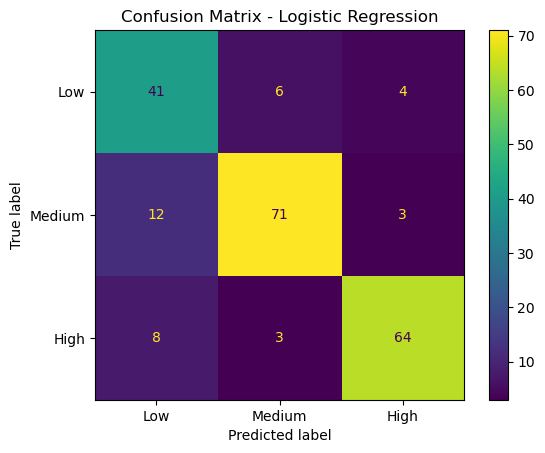


Evaluating K-Nearest Neighbors...
Accuracy for K-Nearest Neighbors: 1.00
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        51
           1       1.00      0.99      0.99        86
           2       1.00      1.00      1.00        75

    accuracy                           1.00       212
   macro avg       0.99      1.00      0.99       212
weighted avg       1.00      1.00      1.00       212



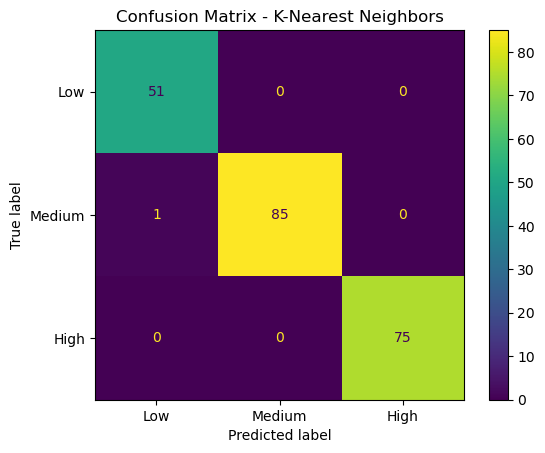


Evaluating Random Forest...
Accuracy for Random Forest: 1.00
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        51
           1       0.99      1.00      0.99        86
           2       1.00      1.00      1.00        75

    accuracy                           1.00       212
   macro avg       1.00      0.99      0.99       212
weighted avg       1.00      1.00      1.00       212



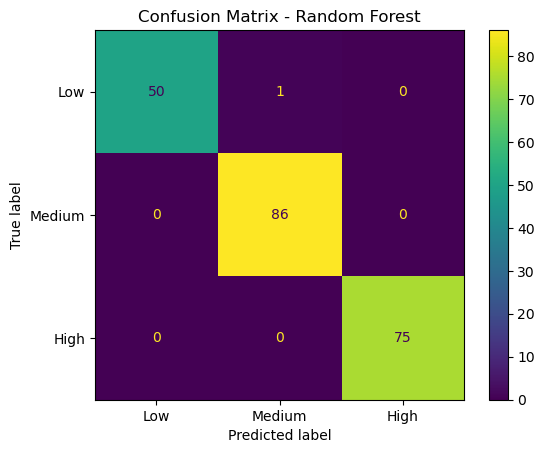

In [48]:
# Evaluate models
results = {}
for name, model in tuned_models.items():
    print(f"\nEvaluating {name}...")
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy for {name}: {accuracy:.2f}")
    print(classification_report(y_test, y_pred))
    results[name] = accuracy

    # Confusion matrix visualization
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=['Low', 'Medium', 'High'])
    plt.title(f"Confusion Matrix - {name}")
    plt.show()


In [50]:
results_df = pd.DataFrame(list(results.items()), columns=['Model', 'Accuracy'])
bar_chart = alt.Chart(results_df).mark_bar().encode(
    y=alt.Y('Model:N', title='Model', sort='x'),  
    x=alt.X('Accuracy:Q', title='Accuracy'),  
    color=alt.Color('Model:N',  scale=alt.Scale(scheme='viridis')),  
    tooltip=['Model', 'Accuracy'] 
).properties(
    title='Model Performance Comparison', 
    width=500,
    height=250
)

bar_chart

alt.Chart(...)

In [51]:
X = full_milk.drop('Grade', axis=1)
y = full_milk['Grade']

y = LabelEncoder().fit_transform(y)
y = to_categorical(y, num_classes=3)  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2025, stratify=y)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax') 
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=50, verbose=0, validation_data=(X_test, y_test))

train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, 51)

data = pd.DataFrame({
    'Epoch': list(epochs) * 4,
    'Value': train_accuracy + val_accuracy + train_loss + val_loss,
    'Type': (['Training Accuracy'] * len(train_accuracy) + 
             ['Validation Accuracy'] * len(val_accuracy) + 
             ['Training Loss'] * len(train_loss) + 
             ['Validation Loss'] * len(val_loss))
})

combined_chart = alt.Chart(data).mark_line().encode(
    x=alt.X('Epoch:O'),
    y=alt.Y('Value:Q'),
    color='Type:N', 
    tooltip=['Epoch', 'Value', 'Type']
).properties(title='Accuracy/Loss', width=650, height=350)
combined_chart

alt.Chart(...)